# randomly select 1000 orgnizations from top 10000, and construct pr-based collabaration networks for those orgnizations

前10000个组织共149347个repos
实验设置：
1 随机实验（重复5次）
   从10000个组织种随机抽取1000-3000-5000-10000个组织，建图，映射到actor
2 顺序实验
   按照活跃排序顺序开始计算
3 两种类型的实验计算：
    （1）最大联通分量的生成过程
    （2）总开发者/最大联通分量开发者
    （3）最大联通分量的度分布
    （4）不同尺度下的最大联通分量的数量 

假设：
     
     按照活跃度排序顺序加入网络，网络的最大联通分量会不断增长
     随着网络规模增长，网络的平均度趋于稳定，度分布函数保持不变
     不同尺度下的度节点比例固定，尺度存在上界
     网络的群聚集系数保持稳定
    

保存：
度分布
   随机抽样的人员
    

In [58]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import time
import pathpy as pp
import matplotlib.pyplot as plt
import networkx as nx
import os
from networkx.algorithms import bipartite

from clickhouse_driver import Client
from pandas.core.frame import DataFrame
from datetime import datetime
import random
from utils import *

In [59]:
RandomN = 1000
community_list = pd.read_csv("csv/top10000_repo_2020.csv")
x = [i for i in range(10000)]
random.seed(10)
random.shuffle(x)
orgs = community_list.org


In [60]:
def compute_network_lcc(B,node_set):
    G = nx.project(B,node_set)
    total_contributor = len(node_set)
    #print ("contributors:",total_contributor)
    largest_components=max(nx.connected_components(G),key=len)
    lcc_ratio=len(largest_components)/len(G.nodes())
    #print("largest_compo/total:",lcc_ratio)
    G_sub=G.subgraph(largest_components)
    lcc_contributor = len(G_sub.nodes())
    #print ("largest_component contributors:", lcc_contributor)
    degree = nx.degree_histogram(G_sub)
    sum_d=0
    for i,d in enumerate(degree):
        sum_d= sum_d+i*d
    avg_degree = sum_d/sum(degree)
    #print ("avarage degree:",avg_degree)
    degree_distribution = [z /float(sum(degree)) for z in degree]
    
    
    return total_contributor, lcc_contributor, lcc_ratio, avg_degree,degree_distribution

In [61]:
%%time
#random experiment
### stored parameter
total_contributors=[]
lcc_contributors=[]
lcc_ratios = []
avg_node_degree =[]
random_degree_distributions = []
B = nx.Graph()

for i in x:
    org = orgs[i]
    print (i,"processing...... ",org)
    node_type={'source':'actor','target':'pr'}
    pr_review_data_path='dataset/pr_review/{org}.csv'.format(org=org)
    df_data = pd.read_csv(pr_review_data_path)
    B = build_bipartite_graph(B,df_data,node_type,'actor_id','issue_id')
    actor_nodes = {n for n, d in B.nodes(data=True) if d['node_type']=='actor'}
    pr_nodes = set(B) - actor_nodes  
    total_contibutor,lcc_contributor,lcc_ratio,avg_degree,degree_distribution=compute_network_lcc(B,actor_nodes)
    total_contributors.append(total_contibutor)
    lcc_contributors.append(lcc_contributor)
    lcc_ratios.append(lcc_ratio)
    avg_node_degree.append(avg_degree)
    random_degree_distributions.append(degree_distribution)
    print ("\n")
df = []
df.append(total_contributors)
df.append(lcc_contributors)
df.append(lcc_ratios)
df.append(avg_node_degree)

columns = ['total_contributors','lcc_contributors','lcc_ratios','avg_node_degree']
df_random = DataFrame(np.transpose(np.asarray(df)),columns=columns)
df_random.to_csv("dataset/result/random_growth_network.csv",index=None)

1620 processing......  gtk-rs


1954 processing......  datastax


8050 processing......  cwida


3036 processing......  AppFolioOnboarding


7397 processing......  r-dbi


734 processing......  distkv-project


1471 processing......  3scale


8907 processing......  FastLED


1513 processing......  tailwindcss


5869 processing......  Cryptonomic


7441 processing......  edumco


7676 processing......  genie-platform


5074 processing......  OpenChemistry


1995 processing......  pmem


4811 processing......  mermaid-js


2017 processing......  m-lab


1468 processing......  liferay


1647 processing......  iovisor


7712 processing......  lagom


9393 processing......  hivehelsinki


9063 processing......  openreview


3923 processing......  GuabinaCore


8330 processing......  bitcoinjs


8513 processing......  OpenRoberta


898 processing......  QubesOS


4550 processing......  appsignal


1344 processing......  nwtgck


2333 processing......  CartoonFan


1635 processing......  Unio

Text(0, 0.5, 'largest connected component ratio')

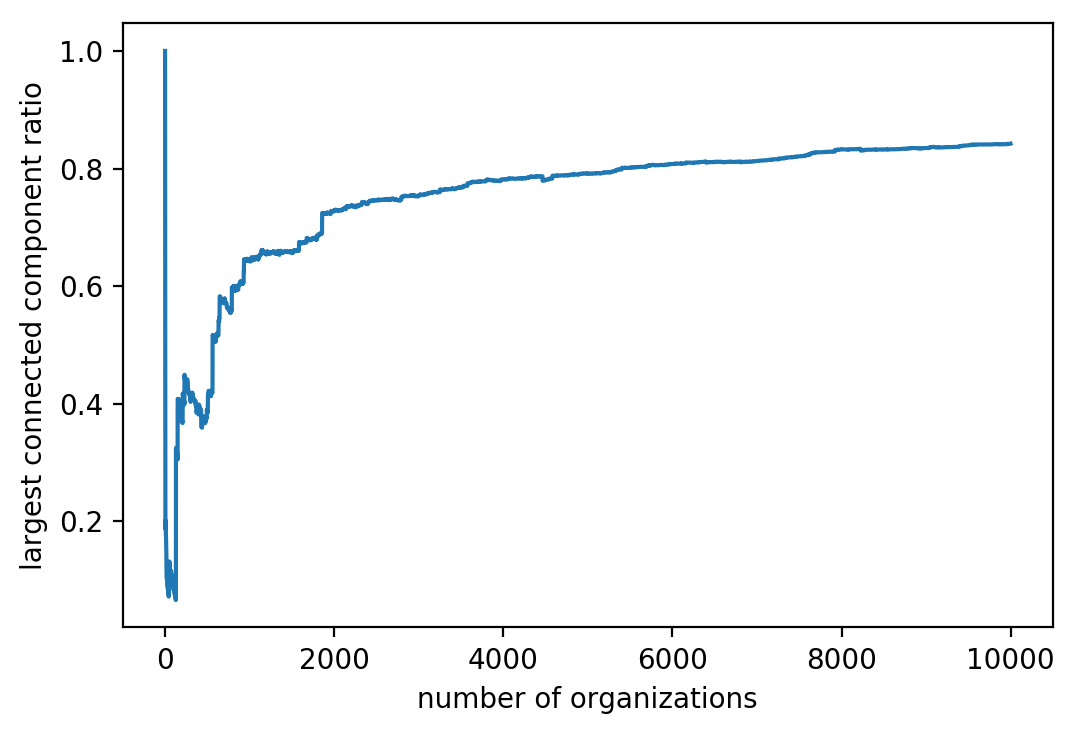

In [74]:
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
plt.plot(lcc_ratios)
plt.xlabel("number of organizations")
plt.ylabel("largest connected component ratio")
#plt.plot(avg_node_degree)

Text(0, 0.5, 'average node degree')

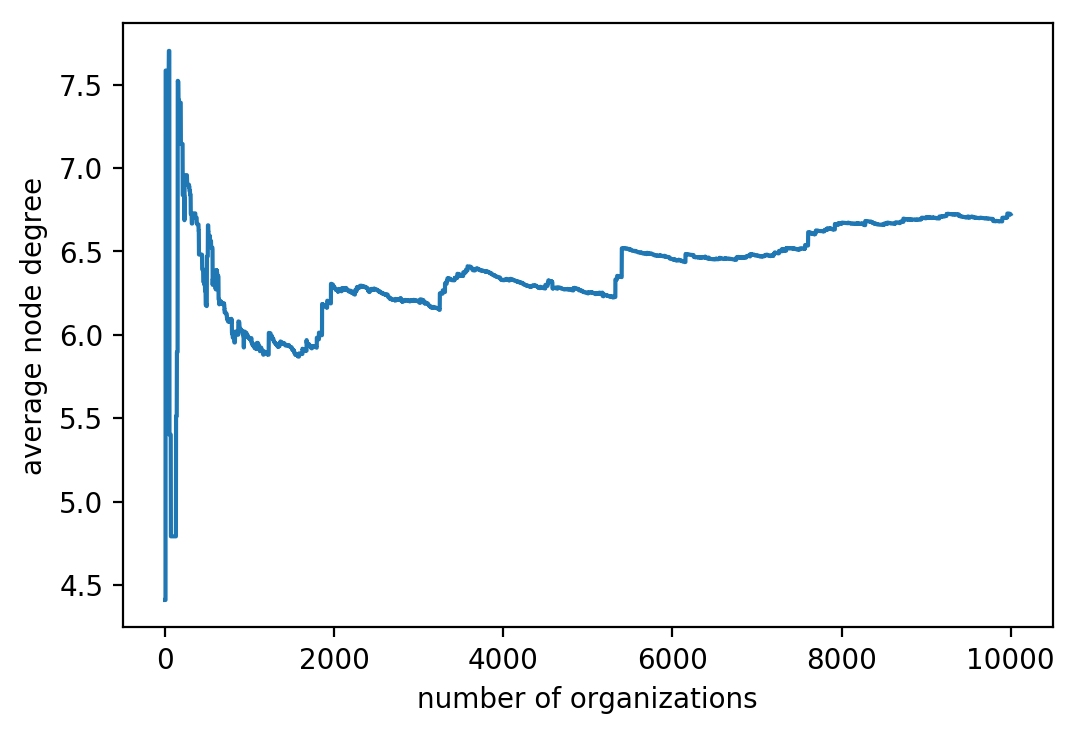

In [75]:
plt.plot(avg_node_degree)
plt.xlabel("number of organizations")
plt.ylabel("average node degree")

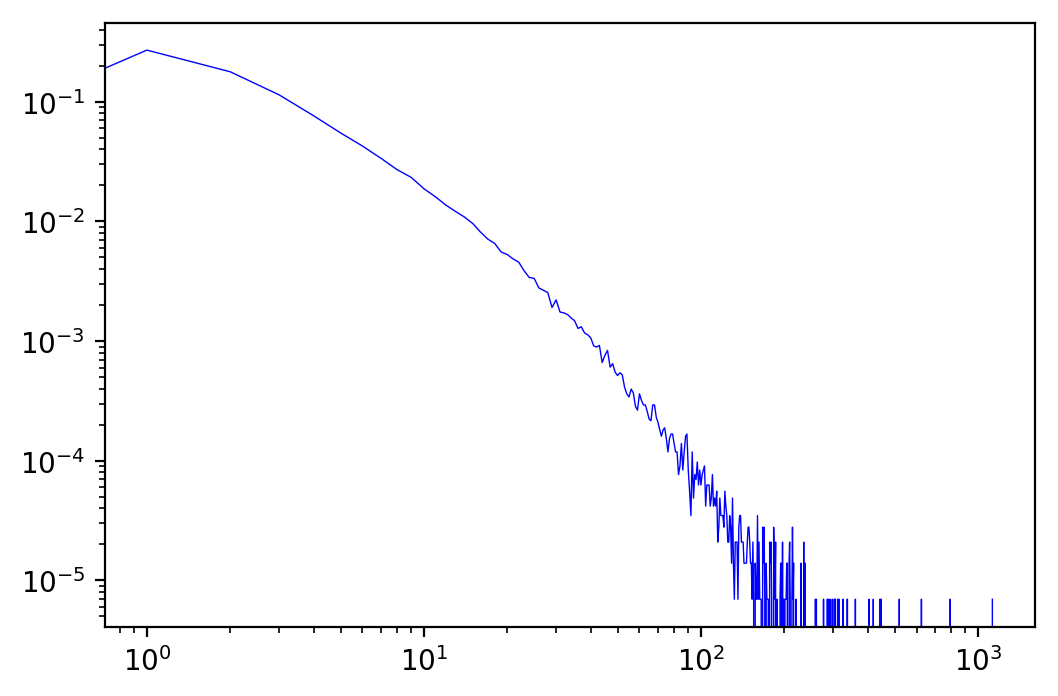

In [84]:
y = random_degree_distributions[-1]
x = range(len(y))
plt.loglog(x,y,color='blue',linewidth=0.5)

In [85]:
actor_nodes = {n for n, d in B.nodes(data=True) if d['node_type']=='actor'}
pr_nodes = set(B) - actor_nodes 
G = nx.project(B,actor_nodes)
degree = nx.degree_histogram(G) 
T = dict(G.degree)
T = sorted(T.items(),key=lambda x:x[1],reverse=True)



(6697940, 1127)
(42910462, 794)
(19940114, 625)
(30008653, 520)
(36754821, 447)
(980082, 443)
(45469, 419)
(3181692, 404)
(170270, 361)
(331852, 338)


In [132]:
High_degree_nodes = []
for i in T:
    node = list(i)
    if node[1]>=10:
        High_degree_nodes.append(node)

In [133]:
actor_list = pd.read_csv("csv/actor_list_2019.csv")

In [134]:
actor_list.head()

,actor_id,actor_login
0,4,wycats
1,7,evanphx
2,17,vanpelt
3,21,technoweenie
4,29,lukas


In [135]:
a=list(actor_list.loc[actor_list.actor_id==6290692].actor_login)
a[0]

'licanhua'

In [136]:
len(High_degree_nodes)

26306

In [137]:
%%time
High_degree_nodes_list=[]
for actor_id,degree in High_degree_nodes:
    actor_name = list(actor_list.loc[actor_list.actor_id==actor_id].actor_login)[0]
    tamp = [actor_id,actor_name,degree]
    High_degree_nodes_list.append(tamp)
High_degree_nodes_list

CPU times: user 23.7 s, sys: 52.8 ms, total: 23.8 s
Wall time: 23.8 s


[[6697940, 'houndci-bot', 1127],
 [42910462, 'golangcibot', 794],
 [19940114, 'codacy-bot', 625],
 [30008653, 'hound[bot]', 520],
 [36754821, 'codeclimate[bot]', 447],
 [980082, 'liggitt', 443],
 [45469, 'ljharb', 419],
 [3181692, 'MartinHjelmare', 404],
 [170270, 'sindresorhus', 361],
 [331852, 'neolit123', 338],
 [22591623, 'sftim', 337],
 [243674, 'nicolas-grekas', 326],
 [5220533, 'chrisburr', 315],
 [855702, 'Centril', 312],
 [953992, 'jreback', 306],
 [1297909, 'nschonni', 305],
 [1163175, 'smarterclayton', 303],
 [439401, 'stof', 298],
 [2584963, 'drashna', 292],
 [2642209, 'stephentoub', 288],
 [1444314, 'balloob', 286],
 [917931, 'BenTheElder', 277],
 [320553, 'scopatz', 261],
 [52195, 'mcollina', 259],
 [609873, 'WillAyd', 238],
 [6668460, 'jkotas', 238],
 [28888242, 'worldofpeace', 235],
 [1312546, 'TomAugspurger', 235],
 [995707, 'OskarStark', 235],
 [6477701, 'HyukjinKwon', 230],
 [822522, 'srowen', 230],
 [4701338, 'akien-mga', 220],
 [235188, 'tedyu', 216],
 [1404810, 'S

In [138]:
columns=["actor_id","actor_login","degree"]
df_High_degree_nodes_list=DataFrame(High_degree_nodes_list,columns=columns)
df_High_degree_nodes_list.to_csv("csv/2019_high_degree_nodes_list.csv",index=None)

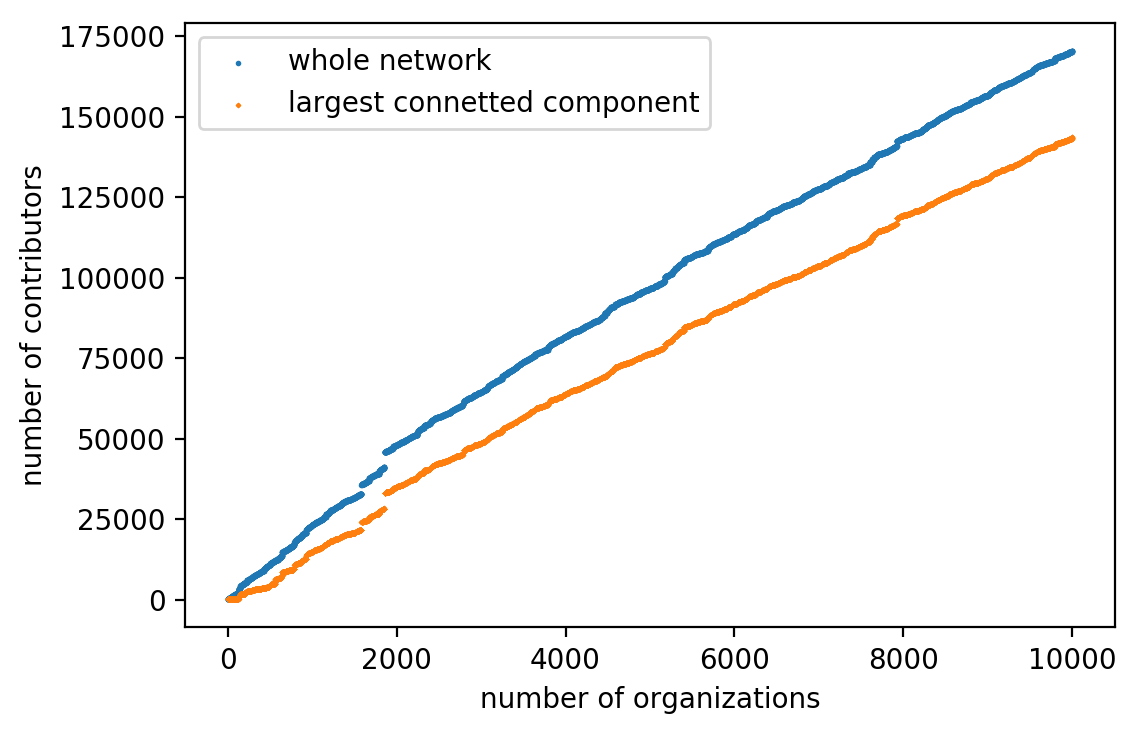

In [81]:
x = [i for i in range(10000)]
plt.scatter(x,total_contributors,s=1,marker="o")
plt.scatter(x,lcc_contributors,s=1,marker = "x")
plt.xlabel("number of organizations")
plt.ylabel("number of contributors")
plt.legend(['whole network','largest connetted component'])

False

In [102]:
B_nodes = B.nodes
B_edges = B.edges
nodes = []
edges = []
for node, node_type in B_nodes(data=True):
    n = [node,node_type['node_type']]
    nodes.append(n)
for edge in B.edges:
    edges.append(list(edge))
column_nodes = ['node_id','node_type']
column_edges = ['actor_node','pr_nodes']
df_nodes  = DataFrame(nodes,columns=column_nodes)
df_edges  = DataFrame(edges,columns = column_edges)


In [106]:
df_nodes.to_csv('csv/2019_Top10000_org_pr_bipartite_network_nodes.csv',index=None)

In [107]:
df_edges.to_csv('csv/2019_Top10000_org_pr_bipartite_network_edges.csv',index=None)

In [97]:
i = 0
for node,node_type in B_nodes(data=True):
    if i<10:
        n = [node,node_type['node_type']]
        print (n)
    i=i+1

[301846, 'actor']
[241568997, 'pr']
[28687262, 'actor']
[584258, 'actor']
[240335711, 'pr']
[72159, 'actor']
[231779600, 'pr']
[3050060, 'actor']
[242492232, 'pr']
[242593582, 'pr']


In [98]:
B_edges = B.edges
i = 0
for edge in B_edges:
    if i<10:
        print (list(edge))
    i=i+1

[301846, 241568997]
[301846, 242492232]
[301846, 242593582]
[301846, 238970647]
[301846, 244217120]
[301846, 244266976]
[301846, 244602434]
[301846, 231779600]
[301846, 244939964]
[301846, 246131026]


In [ ]:
a = 0.4
# 采样数量
samples = 10000
s = np.random.power(a, samples)

/home/tianyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


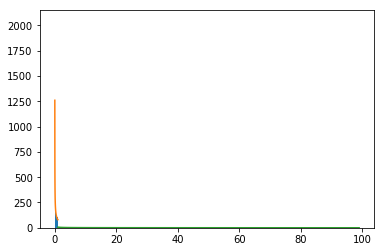

In [18]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, bins=50)
x = np.linspace(0, 1, 100)
y = a*x**(a-1.)
normed_y = samples*np.diff(bins)[0]*y
plt.plot(x, normed_y)
plt.show()

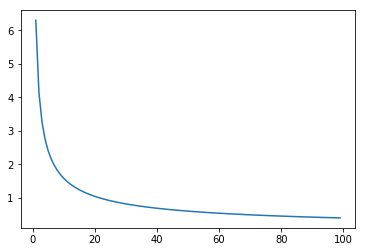

In [19]:
plt.plot(y)

In [8]:
import math
# 分布函数的反函数
def rev(x,a):
    return math.exp(math.log(x) / a)

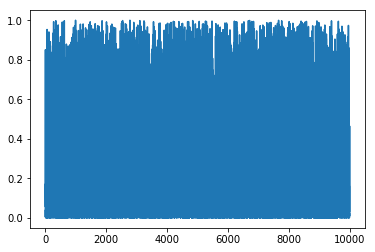

In [20]:
s1 = []
for i in range(samples):
    s1.append(rev(np.random.uniform(0,1),a))

/home/tianyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


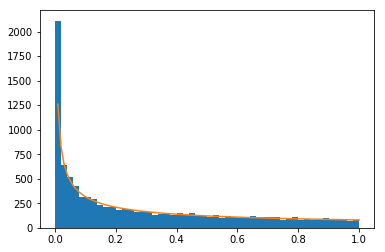

In [10]:
count, bins, ignored = plt.hist(s1, bins=50)
x = np.linspace(0, 1, 100)
y = a*x**(a-1.)
normed_y = samples*np.diff(bins)[0]*y
plt.plot(x, normed_y)
plt.show()
 

In [28]:
divide_num = 100
ys = np.zeros(divide_num)
xs = np.linspace(0,1,divide_num)
for i in range(len(s)):
    ys[int(s[i] * 100)] += 1

In [12]:
from sklearn import linear_model
# 回归
x_log = np.log(xs)
y_log = np.log(ys)
#线性拟合数据准备
X_para=[]
Y_para=[]
for x ,y in zip(x_log[1:],y_log[1:]):
    X_para.append([float(x)])
    Y_para.append(float(y))
# 使用sklearn的线性拟合函数进行拟合
regr = linear_model.LinearRegression()
regr.fit(X_para, Y_para)

/home/tianyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

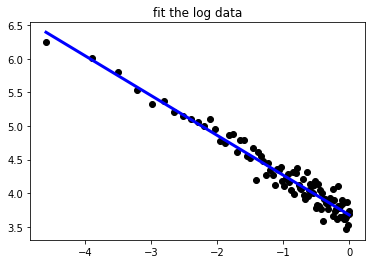

In [13]:
plt.title("fit the log data")
plt.scatter(x_log,y_log,color = "black")
plt.plot(X_para, regr.predict(X_para), color='blue',linewidth=3)
plt.show()